# Book summaries - EDA and data cleaning

The data used in this notebook was downloaded from: https://www.kaggle.com/applecrazy/cmu-book-summary-dataset

In [1]:
import pandas as pd
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict

## Read data

Read data and build lookup dictionaries/dataframes.

In [52]:
file_name = "./raw_data/booksummaries.txt"

In [53]:
wiki_ids = []
freebase_ids = []
titles = []
authors = []
pub_dates = []
genres = []
summaries = []

genre_id_lookup = dict()
genre_to_book_dict = defaultdict(list)
book_to_genre_dict = defaultdict(list)
book_title_dict = dict()
# book_author_dict = dict()
book_summary_dict = dict()

with open(file_name, encoding = 'utf8') as f:
    reader = csv.reader(f, delimiter = "\t")
    for row in reader:
        wiki_ids.append(row[0])
        freebase_ids.append(row[1])
        titles.append(row[2])
        authors.append(row[3])
        pub_dates.append(row[4])
        genres.append(row[5])
        summaries.append(row[6])
        
        book_title_dict[row[0]] = row[2]
        book_summary_dict[int(row[0])] = row[6]
        
        try:
            genre_json = json.loads(row[5])
        except:
            if row[5] != "":
                print(row[0])
                print(row[5])
                break
                
        genre_id_lookup.update(genre_json)
        book_to_genre_dict[row[0]] = list(genre_json.keys())
        for genre_id in genre_json.keys():
            genre_to_book_dict[genre_id].append(row[0])

In [54]:
book_data = pd.DataFrame(list(zip(wiki_ids, freebase_ids, titles, authors, pub_dates, genres, summaries)),
            columns = ["wiki_id","freebase_id","title","author","pub_date","genres","summaries"])

In [55]:
book_data.head()

,wiki_id,freebase_id,title,author,pub_date,genres,summaries
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


## Check data for completeness/correctness

In [56]:
## Does each book have a unique wiki_id?
len(book_data) == len(book_data['wiki_id'].unique())

True

In [57]:
## Does each book have a unique freebase_id?
len(book_data) == len(book_data['freebase_id'].unique())

True

In [58]:
## Does each book have a unique author?
len(book_data) == len(book_data['author'].unique())

False

In [59]:
## Which authors have the most books?
book_data.groupby('author')['wiki_id'].count().sort_values(ascending = False)

author
                       2382
Agatha Christie          74
Franklin W. Dixon        68
K. A. Applegate          62
Stephen King             60
                       ... 
Lillian Hellman           1
Lilias MacBean Hart       1
Liaquat Ahamed            1
Li Zhisui                 1
John de Lancie            1
Name: wiki_id, Length: 4715, dtype: int64

In [60]:
## Which genres have the most books?
genre_counts = pd.DataFrame.from_dict({genre_id_lookup[k]:len(v) for k,v in genre_to_book_dict.items()}, 
                                      orient = "index",
                                     columns = ["count"])
genre_counts.sort_values(by = "count", ascending = False).head(20)

,count
Fiction,5837
Speculative fiction,5255
Science Fiction,3575
Novel,3218
Fantasy,3080
Children's literature,2647
Young adult literature,1118
Crime Fiction,948
Suspense,898
Historical novel,850


In [61]:
## Need to transform book publication dates strings to dates
## There are 4 kinds of date strings found in the dataset
missing_idx = book_data['pub_date'] == ""
year_only_idx = book_data['pub_date'].str.match(r'(^\d{4}$)') == True
ymd_idx = book_data['pub_date'].str.match(r'(^\d{4}-\d{2}-\d{2}$)') == True
year_month_idx = book_data['pub_date'].str.match(r'(^\d{4}-\d{2}$)') == True

In [62]:
book_data['pub_date_cleaned'] = None
book_data.loc[ymd_idx, 'pub_date_cleaned'] = pd.to_datetime(book_data.loc[ymd_idx, 'pub_date'], format = "%Y-%m-%d")
book_data.loc[year_only_idx, 'pub_date_cleaned'] = pd.to_datetime(book_data.loc[year_only_idx, 'pub_date'], format = "%Y", errors = "coerce")
book_data.loc[year_month_idx, 'pub_date_cleaned'] = pd.to_datetime(book_data.loc[year_month_idx, 'pub_date'], format = "%Y-%m", errors = "coerce")


In [63]:
book_data.loc[book_data['pub_date_cleaned'].isna()]

,wiki_id,freebase_id,title,author,pub_date,genres,summaries,pub_date_cleaned
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...,None
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,None
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,,,The story is set in an imaginary American tow...,None
10,4331,/m/01d3j,Book of Joshua,,,,(Chapter 1 is the first of three important mo...,None
11,4332,/m/01d40,Book of Ezra,,,,"For the Bible text, see Bible Gateway (opens ...",None
...,...,...,...,...,...,...,...,...
16540,35802230,/m/0jt8896,De vierde man,,,,The novel is a frame narrative: a writer name...,None
16543,36043883,/m/05h5ndx,Family,,,,The Family focuses on three brothers from the...,None
16548,36303946,/m/0k296wc,Fire Season,Jane Lindskold,,,"Stephanie Harrington and her treecat, Climbs ...",None
16550,36531274,/m/0kfwljn,The Birth of Plenty,William J. Bernstein,,,The Birth of Plenty is an history of the worl...,None


In [64]:
book_data_ts = book_data.loc[~book_data['pub_date_cleaned'].isna()]
book_data_ts['pub_date_cleaned'] = pd.to_datetime(book_data_ts['pub_date_cleaned'])
book_data_ts['pub_date_year'] = book_data_ts['pub_date_cleaned'].dt.year

C:\Users\smont\Anaconda3\envs\msba\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\smont\Anaconda3\envs\msba\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
books_yearly = book_data_ts.groupby('pub_date_year')['wiki_id'].count()

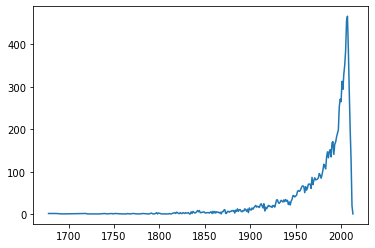

In [66]:
plt.plot(books_yearly)
plt.show()

## Extract fantasy books for future work

In [67]:
## NOTE - this is ugly, refactor this
genre_id_df = pd.DataFrame.from_dict(genre_id_lookup, orient = 'index')
fantasy_id = max(genre_id_df.loc[genre_id_df[0] == "Fantasy"].index.values)
print(fantasy_id)

/m/01hmnh


In [72]:
## Look at the first few fantasy books
for idx, book_id in enumerate(genre_to_book_dict[fantasy_id]):
    print(book_id, book_title_dict[book_id])
    if idx > 10:
        break
    
fantasy_book_ids = genre_to_book_dict[fantasy_id]

2080 A Fire Upon the Deep
2890 A Wizard of Earthsea
2950 Anyone Can Whistle
7923 Dracula
10862 The Metamorphosis
11745 Farmer Giles of Ham
28230 Speaker for the Dead
29798 The Lord of the Rings
29834 The Time Machine
30033 Mort
30292 The Hobbit
30706 The Great Divorce


In [73]:
book_data.loc[book_data['wiki_id'].isin(fantasy_book_ids)]

,wiki_id,freebase_id,title,author,pub_date,genres,summaries,pub_date_cleaned
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,None
6,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...",1968-01-01 00:00:00
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,,,The story is set in an imaginary American tow...,None
26,7923,/m/026l0,Dracula,Bram Stoker,1897,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","The novel is told in epistolary format, as a ...",1897-01-01 00:00:00
34,10862,/m/02y0x,The Metamorphosis,,1915,"{""/m/0dwly"": ""Children's literature"", ""/m/0pym...","One day Gregor Samsa, a traveling salesman, w...",1915-01-01 00:00:00
...,...,...,...,...,...,...,...,...
16531,35311147,/m/0czwqd,Guardians of Ga'Hoole Book 4: The Siege,Helen Dunmore,2004-05-01,"{""/m/014dfn"": ""Speculative fiction"", ""/m/01hmn...",==Receptio,2004-05-01 00:00:00
16532,35471510,/m/0j9q2rv,The Casual Vacancy,J. K. Rowling,2012-09-27,"{""/m/01hmnh"": ""Fantasy"", ""/m/0q9mp"": ""Tragicom...","The novel is split into seven parts, the firs...",2012-09-27 00:00:00
16533,35482946,/m/0bmg3gb,Infected,Scott Sigler,,,The book follows several characters as they d...,None
16534,35587482,/m/0jk_hyr,Raboliot,Maurice Genevoix,1925,,The novel is set in the country-side around L...,1925-01-01 00:00:00


In [74]:
book_data.to_csv("./processed_data/fantasy_book_data.csv", index = False)